In [28]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from scipy.optimize import minimize

<h4>Parameters<h4>

In [29]:
segment_count_beam = 100
vertical_level_count = 100
length_beam = 1000 # mm
horizontal_force = 20 # N, + compression, - tension
youngs_modulus = 2000 # MPa
moment_of_inertia = 20 # mm^4
channel_width_half = 10 # mm
# boundary_penalty_coefficient = 1e1
# pinned_penalty_coefficient = 1e1

In [30]:
3.14**2 * youngs_modulus * moment_of_inertia / length_beam**2

0.394384

<h4>Initial Guess<h4>

In [31]:
# ensure y=0 is possible
if vertical_level_count % 2 == 0:
    vertical_level_count += 1
    print(f"The vertical level count has been adjusted to {vertical_level_count} (was {vertical_level_count-1}).")

# ensure ds>dy_max
if segment_count_beam > length_beam/(2*channel_width_half):
    previous = segment_count_beam
    segment_count_beam = int(length_beam/(2*channel_width_half))
    print(f"The beam segment count has been adjusted to {segment_count_beam} (was {previous}).")

y_levels = np.linspace(-channel_width_half, channel_width_half, vertical_level_count)
s, ds = np.linspace(0, length_beam, segment_count_beam+1, retstep=True)

The vertical level count has been adjusted to 101 (was 100).
The beam segment count has been adjusted to 50 (was 100).


In [32]:
def segment_energy_functional(I_val, J_val, K_val):
    theta1 = np.arcsin((J_val - I_val) / ds)
    theta2 = np.arcsin((K_val - J_val) / ds)

    internal_strain_energy = 0.5 * youngs_modulus * moment_of_inertia * ( (theta2 - theta1)/ds )**2 * ds
    external_force_work = horizontal_force * np.cos(theta1) * ds
    
    return internal_strain_energy + external_force_work

In [33]:
def viterbi_algorithm(vertical_level_count, segment_count_beam, segment_energy_functional):
    C = {}
    survivor = {}
    index_zero = vertical_level_count//2

    for I, J in product(range(vertical_level_count), repeat=2):
        if I == index_zero:
            C[(I, J, 1)] = 0
            survivor[(I, J, 1)] = None
        else:
            C[(I, J, 1)] = np.inf
            survivor[(I, J, 1)] = None

    for m in range(2, segment_count_beam + 1):
        for J, K in product(range(vertical_level_count), repeat=2):
            best_cost = np.inf
            best_prev_I = None

            for I in range(vertical_level_count):
                prev_state_key = (I, J, m - 1)
                prev_cost = C.get(prev_state_key, np.inf)

                if prev_cost == np.inf:
                    continue

                trans_cost = segment_energy_functional(y_levels[I], y_levels[J], y_levels[K])
                total_cost = prev_cost + trans_cost

                if total_cost < best_cost:
                    best_cost = total_cost
                    best_prev_I = I

            C[(J, K, m)] = best_cost
            survivor[(J, K, m)] = best_prev_I

    min_cost = np.inf
    best_final_key = None

    for J, K in product(range(vertical_level_count), repeat=2):
        current_key = (J, K, segment_count_beam)
        cost = C.get(current_key, np.inf)
        if cost < min_cost and K == index_zero:
            min_cost = cost
            best_final_key = current_key

    if best_final_key is None or min_cost == np.inf:
        print("No valid path found (possibly all paths lead to infinite cost).")
        return []
    else:
        path_indices = []
        current_J, current_K, current_m = best_final_key

        path_indices.append(current_K)
        path_indices.append(current_J)

        for m_step in range(segment_count_beam, 1, -1):
            prev_I = survivor[(current_J, current_K, m_step)]
            if prev_I is None:
                break
            path_indices.append(prev_I)
            current_K = current_J 
            current_J = prev_I


        final_J, final_K, _ = best_final_key
        reconstructed_y_indices = [final_K]
        reconstructed_y_indices.append(final_J)

        current_J_trace = final_J
        current_K_trace = final_K

        for m_trace in range(segment_count_beam, 1, -1):
            prev_I_trace = survivor[(current_J_trace, current_K_trace, m_trace)]
            if prev_I_trace is None:
                break
            reconstructed_y_indices.append(prev_I_trace)
            current_K_trace = current_J_trace
            current_J_trace = prev_I_trace

        reconstructed_y_indices.reverse()
        y_viterbi = [y_levels[i] for i in reconstructed_y_indices]
        return y_viterbi


In [34]:
def x_from_y(y):
    dy = np.diff(y)
    dx = np.sqrt(ds**2 - dy**2)
    x = np.cumulative_sum(dx, include_initial=True)
    return x

In [35]:
y_viterbi = viterbi_algorithm(vertical_level_count, segment_count_beam, segment_energy_functional)
x_viterbi = x_from_y(y_viterbi)
print(f"Δx = {x_viterbi[-1]-length_beam:.1f} mm")

# plt.figure()
# plt.plot(s, y_viterbi, marker="", linestyle="--", label = "y(s)")
# plt.plot(x_viterbi, y_viterbi, marker="", linestyle="--", label="y(x)")
# plt.axhline(channel_width_half)
# plt.axhline(-channel_width_half)
# plt.grid()
# plt.legend()
# plt.ylabel("y [mm]")
# plt.axis("equal")
# plt.show()

Δx = -6.5 mm


In [36]:
def energy_functional(y):
    v = 0
    for i in range(len(y)-2):
        theta1 = np.arcsin((y[i+1] - y[i]) / ds)
        theta2 = np.arcsin((y[i+2] - y[i+1]) / ds)
        kappa = (theta2 - theta1) / ds
        internal_strain_energy = 0.5 * youngs_modulus * moment_of_inertia * kappa**2 * ds
        external_force_work = horizontal_force * np.cos(theta1) * ds
        v += internal_strain_energy + external_force_work
    return v

In [37]:
res = minimize( energy_functional, 
                x0=y_viterbi, 
                constraints = [{"type": "eq", "fun": lambda y: y[-1]},
                               {"type": "eq", "fun": lambda y: y[0]}],
                bounds = [(-channel_width_half, channel_width_half)
                           for _ in range(segment_count_beam+1)],
                method="SLSQP"
                )

y_minimized = res.x
x_minimized = x_from_y(y_minimized)

In [38]:
header = f'{"PARAMETER":<25}  {"VALUE":<10}  {"UNIT":<10}'

parameters_data = [
    ("Beam Segment Count", segment_count_beam, ""),
    ("Vertical Level Count", vertical_level_count, ""),
    ("Beam Length", length_beam, "mm"),
    ("Horizontal Force", horizontal_force, "N"),
    ("Young's Modulus", youngs_modulus, "MPa"),
    ("Moment of Inertia", moment_of_inertia, "mm^4"),
    ("Channel Half-Width", channel_width_half, "mm"),
    # ("Boundary Penalty Coeff", f"{boundary_penalty_coefficient:.0e}", ""),
    # ("Pinned Penalty Coeff", f"{pinned_penalty_coefficient:.0e}", ""),
    ("Beam End x-Displacement", f"{x_minimized[-1]-length_beam:.1f}", "mm"),

]

body_lines = []
for name, value, unit in parameters_data:
    value_str = str(value)
    body_lines.append(f"{name:<25}  {value_str:<10}  {unit:<10}")

solver_params_string = "\n".join([
    header,
    *body_lines
])

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 19538.971660980907
       x: [ 0.000e+00 -3.503e+00 ... -2.474e+00  0.000e+00]
     nit: 41
     jac: [-1.173e+00  0.000e+00 ...  0.000e+00 -6.230e-01]
    nfev: 2185
    njev: 41


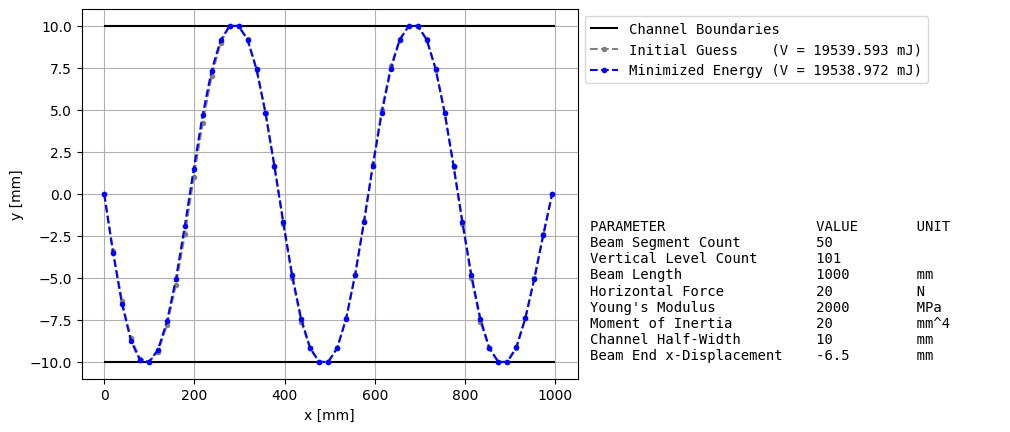

In [39]:
print(res)

plt.hlines(channel_width_half, 0, length_beam, color="black", label="Channel Boundaries")
plt.hlines(-channel_width_half, 0, length_beam, color="black")
plt.plot(x_viterbi, y_viterbi, marker=".", linestyle="--", color="grey",
          label=f"Initial Guess    (V = {energy_functional(y_viterbi):.3f} mJ)")
plt.plot(x_minimized, y_minimized, marker=".", linestyle="--", color="blue",
          label=f"Minimized Energy (V = {res.fun:.3f} mJ)")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), prop="monospace")
plt.figtext(0.92, 0.15, solver_params_string, fontfamily="monospace")
plt.xlabel("x [mm]")
plt.ylabel("y [mm]")
# plt.axis("equal")
plt.grid()
plt.show()